## Clean Data
- rename file: from 02020021rest 20150707 1720.mat -> 02020021.mat

In [ ]:
# import os
# import scipy.io as sio
# import numpy as np

# eegPath = "brain-mdd/dataset"
# newEEGPath = "brain-mdd/clean_dataset"

# for filename in os.listdir(eegPath):
#     if filename.endswith(".mat") or filename.endswith("..mat"):
#         data = sio.loadmat(eegPath + "/" + filename)
#         getKey = "a" + filename
#         getKey = getKey.replace(" ", "_")
#         getKey = getKey.replace("..", "")
#         getKey = getKey.replace(".", "")
#         if getKey in data:
#             temp = data[getKey]
#             newFilename = filename[:8]
#             np.save(newEEGPath + "/" + newFilename, temp)
#         else:
#             print(f"Key {getKey} not found in {filename}")
#     else:
#         print("Skipping " + filename)

## Inspect Data



In [ ]:
import dotenv
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import enum
import mne

dotenv.load_dotenv()

class ChannleMapping(enum.Enum):
    FP1 = 22
    FP2 = 9
    F3 = 24
    F4 = 124
    C3 = 36
    C4 = 104
    P3 = 52
    P4 = 92
    O1 = 70
    O2 = 83
    F7 = 33
    F8 = 122
    T3 = 45
    T4 = 108
    T5 = 58
    T6 = 96

In [ ]:
# Get the path to the EEG data and report
eegPath = os.getenv("EEG_DIR_PATH")
reportPath = os.getenv("EEG_REPORT_PATH")

report = pd.read_excel(reportPath)
reportDf = pd.DataFrame(report)
reportDf

In [ ]:
filename = "02010004.npy"
data = np.load(eegPath + "/" + filename)

selectedChannelsEeg = []

for channel in ChannelMapping:
    print(channel)
    selectedChannelsEeg.append(data[channel.value])
    
# cast to 2 dimensional array
selectedChannelsEeg = np.array(selectedChannelsEeg)
selectedChannelsEeg = selectedChannelsEeg
selectedChannelsEeg.shape

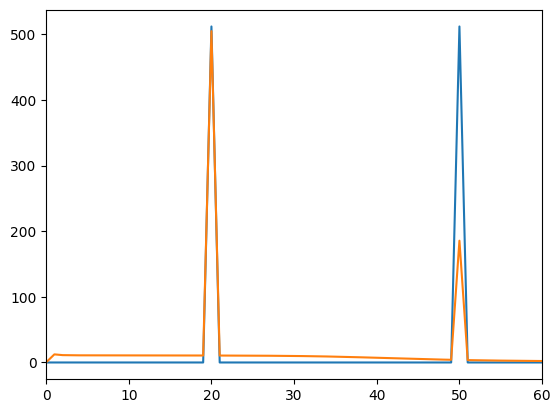

In [12]:
# generate sine wave of 20hz + 50hz
from scipy.signal import butter, lfilter

def fftProcess(inputBuffer):
    fftResults = []
    for channelData in inputBuffer:
        fftData = np.fft.fft(channelData)
        fftData = np.abs(fftData)
        fftData = fftData[0:int(len(channelData)/2)]
        fftResults.append(fftData)
    return fftResults

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

fs = 512*2
t = np.arange(0, 1024) / fs
signal = np.sin(2 * np.pi * 20 * t) + np.sin(2 * np.pi * 50 * t)
fftOri = np.fft.fft(signal)
fftOri = np.abs(fftOri)
fftOri = fftOri[0:int(len(fftOri)/2)]

filteredSignal = butter_bandpass_filter(signal, 0.5, 40, fs, order=4)
filteredFft = np.fft.fft(filteredSignal)
filteredFft = np.abs(filteredFft)
filteredFft = filteredFft[0:int(len(filteredFft)/2)]

# use my fft process


# plot compare between filtered and unfiltered signal
plt.plot(fftOri)
plt.plot(filteredFft)
plt.xlim(0, 60)
plt.show()

In [ ]:
rawData = np.load(eegPath + "/raw/02020010.npy")
eegData = np.load(eegPath + "/16channels/02020010.npy")
print(rawData.shape)
print(eegData.shape)

channelNames = [channel.name for channel in ChannelMapping]
channelTypes = ['eeg'] * len(channelNames)

sfreq = 250
info = mne.create_info(channelNames, sfreq, channelTypes)
raw = mne.io.RawArray(eegData, info)

montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

raw.plot_psd(fmin=0.5, fmax=40, average=True, spatial_colors=True) # plot power spectral density
raw.plot(n_channels=16, scalings='auto', title='Original')

# Bandpass filter 0.5-40 Hz
lowcut = 0.5
highcut = 40
raw.filter(lowcut, highcut, fir_design='firwin', skip_by_annotation='edge')

# ICA
ica = mne.preprocessing.ICA(n_components=16, random_state=42, max_iter='auto')
ica.fit(raw)
ica.plot_components()
raw = ica.apply(raw)

raw.plot_psd(fmin=0.5, fmax=40, average=True, spatial_colors=True)
raw.plot(n_channels=16, scalings='auto', title='After ICA')